<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/visual_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Networks and the Art Market: A Deep Learning Approach to Valuation**


In [1]:

import os
import shutil
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets, transforms


!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    data_filter as data_filter,
    add_prev_avg_price as add_prev_avg_price,
    load_image_data as load_image_data,
    check_image_existence as check_image_existence,
    filter_data_for_missing_images as filter_data_for_missing_images,
    resnet_transform as resnet_transform,
    column_type_split as column_type_split,
    add_global_prev_avg_price as add_global_prev_avg_price
)

Mounted at /content/drive


In [2]:
class MixedTransactionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, numerical_cols, artist_cols, medium_cols, transaction_house_cols, base_dir , transform=resnet_transform()):

        # Extract numerical features
        self.numerical_features = X[numerical_cols].reset_index(drop=True).values.astype('float32')

        # Extract categorical one-hot encoded features
        self.artists = X[artist_cols].reset_index(drop=True).values.astype('float32')
        self.mediums = X[medium_cols].reset_index(drop=True).values.astype('float32')
        self.transaction_houses = X[transaction_house_cols].reset_index(drop=True).values.astype('float32')

        #image path and transform
        self.image_paths = [os.path.join(base_dir, path.lstrip('/')) for path in X['image_url'].dropna()]
        self.transform = transform

        # Target variable
        self.y = y.reset_index(drop=True).values.astype('float32')

    def __getitem__(self, idx):

        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)

             # Concatenate all features into a single tensor
        x = np.concatenate([
            self.numerical_features[idx],  # height, width, prev_avg_price, prev_global_avg_price
            self.artists[idx],
            self.mediums[idx],
            self.transaction_houses[idx]
        ]).astype('float32')
        return torch.tensor(x, dtype=torch.float32), image, torch.tensor(self.y[idx], dtype=torch.float32)

    def __len__(self):
        return len(self.y)



def create_dataloaders(X_train, X_test, y_train, y_test,numerical_cols=['height', 'width', 'prev_avg_price', 'prev_global_avg_price'],
                       base_dir= "/content/data",  batch_size=128):
    # Create the training dataset and dataloader
    numerical_cols, artist_cols, medium_cols, transaction_house_cols = column_type_split(X_train, X_test,numerical_cols)
    train_dataset = MixedTransactionDataset(X_train, y_train, artist_cols, medium_cols, transaction_house_cols, numerical_cols, base_dir)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2,drop_last=True)
    # Create the testing dataset and dataloader
    test_dataset = MixedTransactionDataset(X_test, y_test, artist_cols, medium_cols, transaction_house_cols, numerical_cols,base_dir)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=2,drop_last=True)

    return train_loader, test_loader



class FeatureProjection(nn.Module):
    def __init__(self, in_features, output_dim=30):
        super(FeatureProjection, self).__init__()
        self.fc = nn.Linear(in_features, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))

class CombinedModel(nn.Module):
    def __init__(self, num_artists, num_mediums, num_transaction_houses, projection_dim=30, fine_tune = True):
        super(CombinedModel, self).__init__()
        self.num_artists = num_artists
        self.num_mediums = num_mediums
        self.num_transaction_houses = num_transaction_houses

        self.height_projection = FeatureProjection(1, projection_dim)
        self.width_projection = FeatureProjection(1, projection_dim)
        self.prev_avg_price_projection = FeatureProjection(1, projection_dim)
        self.prev_global_avg_price_projection = FeatureProjection(1, projection_dim)
        self.artist_projection = FeatureProjection(num_artists, projection_dim)
        self.medium_projection = FeatureProjection(num_mediums, projection_dim)
        self.transaction_house_projection = FeatureProjection(num_transaction_houses, projection_dim)



        # image feature part
        image_model = torchvision.models.resnet50(weights="DEFAULT")
        num_features = image_model.fc.in_features
        image_model.fc = nn.Linear(num_features, projection_dim)
        self.image_model = image_model
        if fine_tune == False: # only fine_tune last layer
            for param in self.image_model.parameters():
                param.requires_grad = False
            for param in self.image_model.fc.parameters():
                param.requires_grad = True

        input_size = 8 * projection_dim
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64,32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32,1)
        self.relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)


    def forward(self,x, image):
        height_proj = self.height_projection(x[:, [0]])  # Extract height column
        width_proj = self.width_projection(x[:, [1]])  # Extract width column
        prev_avg_price_proj = self.prev_avg_price_projection(x[:, [2]])  # Extract prev_avg_price
        prev_global_avg_price_proj = self.prev_global_avg_price_projection(x[:, [3]])  # Extract prev_global_avg_price

        artist_proj = self.artist_projection(x[:, 4:4 + self.num_artists])  # Extract artist columns
        medium_proj = self.medium_projection(x[:, 4 + self.num_artists:4 + self.num_artists + self.num_mediums])  # Extract medium columns
        transaction_house_proj = self.transaction_house_projection(
            x[:, 4 + self.num_artists + self.num_mediums: 4 + self.num_artists + self.num_mediums + self.num_transaction_houses])  # Extract transaction house columns


        # get image features
        img_features = self.image_model(image)
        combined = torch.cat((height_proj, width_proj, prev_avg_price_proj,prev_global_avg_price_proj, artist_proj, medium_proj, transaction_house_proj, img_features), dim=1)

        # feed forward through the network
        combined = self.relu(self.bn1(self.fc1(combined)))
        combined = self.dropout(combined)
        combined = self.relu(self.bn2(self.fc2(combined)))
        combined = self.dropout(combined)
        combined = self.relu(self.bn3(self.fc3(combined)))
        output = self.fc4(combined)
        return output




def train(network, trainloader, testloader, epochs=100, eta=0.001):
    optimizer = torch.optim.Adam(network.parameters(), lr=eta, weight_decay=1e-5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, image, t in trainloader:
          network.train()
          optimizer.zero_grad()
          x, image, t = (x.to(device), image.to(device), t.to(device))

          prediction = network(x, image)
          t= t.view(-1, 1)
          J = loss(prediction, t)

          J_train += J.item() * x.size(0)
          total_train_samples += x.size(0)

          J.backward()
          optimizer.step()


        # Compute average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, image, t in testloader:
                x, image, t = (x.to(device), image.to(device), t.to(device))
                prediction = network(x, image)
                t= t.view(-1, 1)
                J_test += loss(prediction, t).item() * x.size(0)
                total_test_samples += x.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples

        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # Save predictions and targets after last epoch
    pred, target_vals = [], []
    with torch.no_grad():
        network.eval()
        for x, image, t in testloader:
            x, image, t = (x.to(device), image.to(device), t.to(device))
            prediction = network(x, image)
            pred.extend(prediction.view(-1).detach().cpu().numpy())
            target_vals.extend(t.view(-1).detach().cpu().numpy())

    return network, pred, target_vals


In [ ]:
if __name__ == '__main__':

  # Mount Google Drive
  drive.mount('/content/drive')
  # Define source and destination paths
  source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
  destination_path = "/content/drive/My Drive/visual_model.ipynb"

  # Check if the source file exists before moving
  if os.path.exists(source_path):
    # Move the file
    shutil.move(source_path, destination_path)
    print(f"Notebook moved to: {destination_path}")


  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # image data
  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)

  # Check for missing images
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
  # check functioning of image data after filtering
  print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")


  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year_semi', 'image_url','transaction_date']
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house']



  numerical_cols = ['height', 'width', 'prev_avg_price', 'prev_global_avg_price']




  X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                   selected_vars,
                                                   one_hot_vars,
                                                 2020)


  numerical_cols, artist_cols, medium_cols, transaction_house_cols = column_type_split(X_train, X_test, numerical_cols)

  train_loader, test_loader = create_dataloaders(X_train, X_test, pd.DataFrame(y_train),
                                                 pd.DataFrame(y_test))




  model = CombinedModel(len(artist_cols), len(medium_cols), len(transaction_house_cols),fine_tune = False)


  # Train the model
  CombinedModel, prediction_combined_model, target = train(model, train_loader,
                                                           test_loader,
                                                           epochs = 20)

  print(f"Total test batches: {len(test_loader)}")
  print(f"Total test samples: {len(y_test)}")
  print(f"Test data shape : {X_test.shape}")
  print(f"Train data shape : {X_train.shape}")
  print("Std of y_test:", np.std(y_test))
  print("Std of predictions:", np.std(prediction_combined_model))



  # Train the model using the training data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)





















R-squared: 0.355


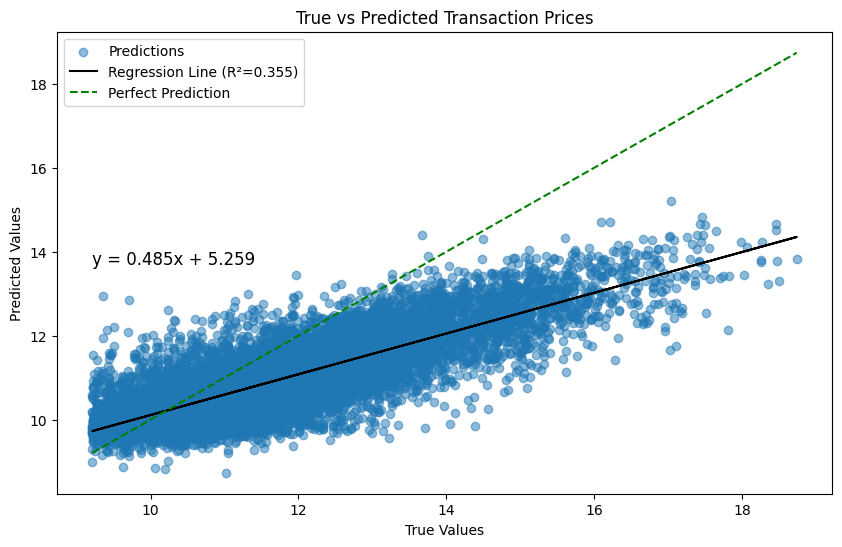

In [6]:
 fit_visualization(target, prediction_combined_model)